# Clustering analysis of functional connectome

In [39]:
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt

import os
import glob

In [87]:
# load shen atlas
atlas_filename = '/home/rj299/scratch60/ra_ptsd/shen_atlas/shen_1mm_268_parcellation.nii.gz'
atlas_labels = pd.read_csv('/home/rj299/scratch60/ra_ptsd/shen_atlas/shen_268_parcellation_networklabels.csv')
# colors = pd.read_csv('/home/rj299/scratch60/ra_ptsd/shen_atlas/shen_268_parcellation_networklabels_colors.csv')
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

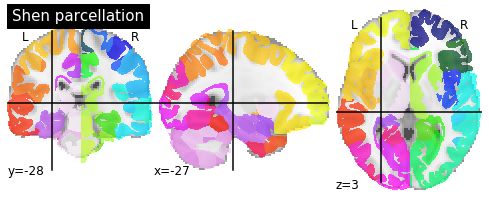

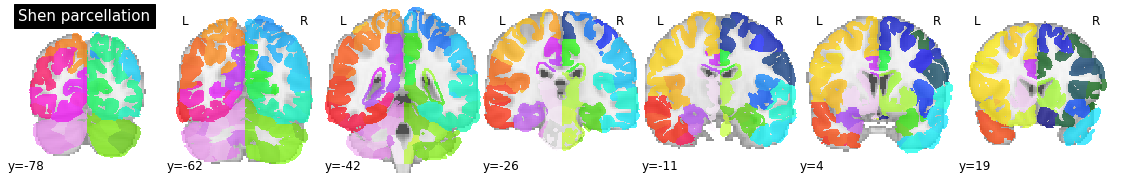

In [155]:
# plot shen parcellation
plotting.plot_roi(atlas_filename, title="Shen parcellation")
plotting.plot_roi(atlas_filename, title="Shen parcellation", display_mode="y")

In [40]:
# read run id
run_id = pd.read_csv('/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/run_id.csv')

Read connectivity matrix

Individual scan run

In [33]:
conn_matrix = np.loadtxt('/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-1234ses-1_bis_matrix_1_matrix.txt')

In [23]:
conn_matrix.shape

(268, 268)

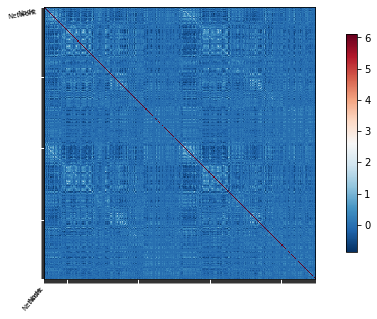

In [34]:
plotting.plot_matrix(conn_matrix, labels=atlas_labels,
#                      vmax=0.8, vmin=-0.8, 
                     colorbar=True)

In [35]:
np.fill_diagonal(conn_matrix, 0)

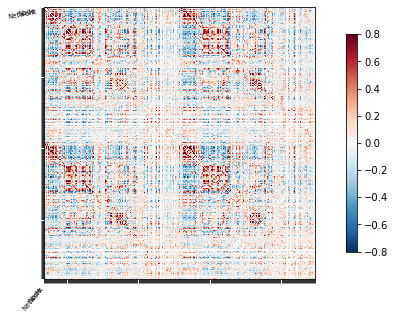

In [37]:
plotting.plot_matrix(conn_matrix, labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, 
                     colorbar=True)

Visualize connectome based on the Shen parcelation

In [ ]:
# view connectome
plotting.view_connectome(conn_matrix, edge_threshold=0.8,
                         node_coords=coords)

Load singel subjects, average gains and losses

In [41]:
run_id.head()

id  ses  run type  isExcluded_behavior  isExcluded_imaging scanner  \
0  1005    1    1    g                  0.0                 0.0     3TA   
1  1005    1    2    g                  0.0                 0.0     3TA   
2  1005    1    3    l                  0.0                 0.0     3TA   
3  1005    1    4    l                  0.0                 0.0     3TA   
4  1005    1    5    r                  0.0                 0.0     3TA   

   isCompleteClinical_PCA   age  isMale   kbit group _merge  
0                     1.0  29.9     1.0  120.0     R   both  
1                     1.0  29.9     1.0  120.0     R   both  
2                     1.0  29.9     1.0  120.0     R   both  
3                     1.0  29.9     1.0  120.0     R   both  
4                     1.0  29.9     1.0  120.0     R   both

In [62]:
# read all matrix files from a subject
sub_id = 1234
sub_run_id = run_id.loc[run_id['id'] == sub_id,:]

all_file = glob.glob('/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-%s*_bis_matrix_*_matrix.txt' %sub_id)


In [84]:
# separate scan types

conn_matrix_gain = []
conn_matrix_loss = []

# gains
ses = np.array(sub_run_id.loc[sub_run_id['type']=='g','ses'])
run = np.array(sub_run_id.loc[sub_run_id['type']=='g','run'])
print('gains')
print(ses)
print(run)

for idx in range(len(ses)):
    filename = '/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-%sses-%s_bis_matrix_%s_matrix.txt' %(sub_id, ses[idx], run[idx])
    if filename in all_file:
        conn_matrix = np.loadtxt(filename)
        np.fill_diagonal(conn_matrix, 0)
        conn_matrix_gain.append(conn_matrix)
    
# losses
ses = np.array(sub_run_id.loc[sub_run_id['type']=='l','ses'])
run = np.array(sub_run_id.loc[sub_run_id['type']=='l','run'])
print('losses')
print(ses)
print(run)

for idx in range(len(ses)):
    filename = '/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-%sses-%s_bis_matrix_%s_matrix.txt' %(sub_id, ses[idx], run[idx])
    if filename in all_file:
        conn_matrix = np.loadtxt(filename)
        np.fill_diagonal(conn_matrix, 0)
        conn_matrix_loss.append(conn_matrix)

gains
[1 1 2 2]
[1 2 3 4]
losses
[1 1 2 2]
[3 4 1 2]


In [98]:
# averaging
conn_matrix_gain_mean = np.mean(conn_matrix_gain, axis=0)
conn_matrix_gain_mean.shape

conn_matrix_loss_mean = np.mean(conn_matrix_loss, axis=0)
conn_matrix_loss_mean.shape

(268, 268)

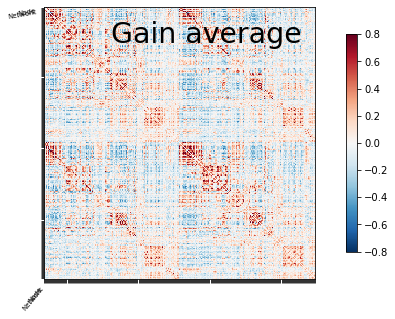

In [96]:
plotting.plot_matrix(conn_matrix_gain_mean, labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, 
                     colorbar=True,
                     title="Gain average")

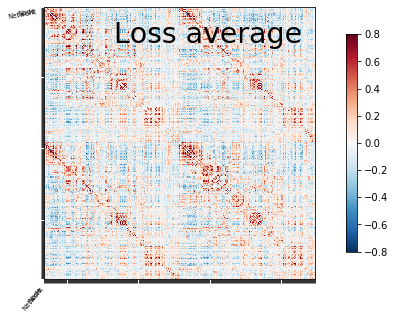

In [99]:
plotting.plot_matrix(conn_matrix_loss_mean, labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, 
                     colorbar=True,
                     title="Loss average")

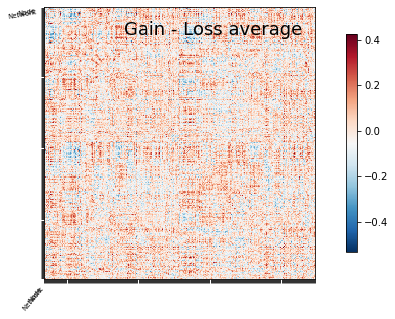

In [101]:
plotting.plot_matrix(conn_matrix_gain_mean - conn_matrix_loss_mean, labels=atlas_labels,
#                      vmax=0.8, vmin=-0.8, 
                     colorbar=True,
                     title="Gain - Loss average")

In [160]:
# view connectome
plotting.view_connectome(conn_matrix_gain_mean - conn_matrix_loss_mean,
                         edge_threshold=0.3,
                         node_coords=coords)

Reshape matrix

In [105]:
def half_matrix(matrix):
    ''' Take half of the correlation matrix, excluding diagnoal
    Input:
        matrix
    
    Output:
        half_matrix: matrix with the upper half and diagnal equals to nan
        vector: vector of the half matrix, without nan
    '''
    
    half_matrix = matrix.copy()
    
    vector = []
    for i in range(half_matrix.shape[0]):
        for j in range(half_matrix.shape[1]):
            if i-j <= 0:
                half_matrix[i,j] = np.nan
            else:
                vector.append(half_matrix[i,j])
    
    return half_matrix, np.array(vector)

In [106]:
half_matrix_gain, gain_vector = half_matrix(conn_matrix_gain_mean)

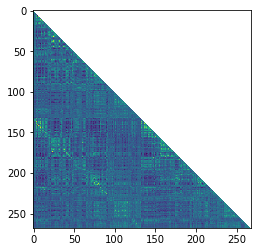

In [109]:
plt.imshow(half_matrix_gain)

### Get all subjects' data

In [214]:
# all subject id and groups
sub_group = run_id.filter(items=["id", "group"])
sub_group.drop_duplicates(inplace=True)

In [215]:
sub_group.head()
# len(sub_group)

id group
0   1005     R
9   1063     C
18  1069     C
27  1072     C
36  1074     P

In [216]:
data_vector = [] # row: subject, columns: voxel
data_matrix = []
sub_list = [] # subject id
group = [] # ptsd, remitted, or control

for idx in range(len(sub_group)):
    sub_id = sub_group['id'].iloc[idx]
    group_name = sub_group['group'].iloc[idx]
    # all matrices of this subject
    all_file = glob.glob('/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-%s*_bis_matrix_*_matrix.txt' %sub_id)


    sub_run_id = run_id.loc[run_id['id'] == sub_id,:]
    
    conn_matrix_gain = []
    conn_matrix_loss = []

    # gains
    ses = np.array(sub_run_id.loc[sub_run_id['type']=='g','ses'])
    run = np.array(sub_run_id.loc[sub_run_id['type']=='g','run'])
#     print('gains')
#     print(ses)
#     print(run)

    for idx in range(len(ses)):
        filename = '/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-%sses-%s_bis_matrix_%s_matrix.txt' %(sub_id, ses[idx], run[idx])
        # if the matrix exist
        if filename in all_file:
            conn_matrix = np.loadtxt(filename)
            np.fill_diagonal(conn_matrix, 0)
            conn_matrix_gain.append(conn_matrix)

    # losses
    ses = np.array(sub_run_id.loc[sub_run_id['type']=='l','ses'])
    run = np.array(sub_run_id.loc[sub_run_id['type']=='l','run'])
#     print('losses')
#     print(ses)
#     print(run)

    for idx in range(len(ses)):
        filename = '/home/rj299/scratch60/ra_ptsd/data_bids/derivatives/matrices/sub-%sses-%s_bis_matrix_%s_matrix.txt' %(sub_id, ses[idx], run[idx])
        
        if filename in all_file:
            conn_matrix = np.loadtxt(filename)
            np.fill_diagonal(conn_matrix, 0)
            conn_matrix_loss.append(conn_matrix)    
    
    # averaging, half_matrix, and convert to vector
    conn_matrix_gain_mean = np.mean(conn_matrix_gain, axis=0)
    conn_matrix_loss_mean = np.mean(conn_matrix_loss, axis=0)
    
    conn_matrix_contrast = conn_matrix_gain_mean - conn_matrix_loss_mean
    
    if ~np.isnan(np.sum(conn_matrix_contrast)):
        half_matrix_contrast, vector = half_matrix(conn_matrix_contrast)

        # append
        data_vector.append(vector)
        data_matrix.append(conn_matrix_contrast)
        group.append(group_name)
        sub_list.append(sub_id)


In [217]:
# check how many subjects, and length of three lists must agree
print(len(data_vector), len(data_matrix), len(sub_list), len(group))

97 97 97 97


In [220]:
# trun group labels into numeric
group

['R',
 'C',
 'C',
 'C',
 'P',
 'R',
 'P',
 'C',
 'C',
 'C',
 'C',
 nan,
 'R',
 'R',
 'P',
 'P',
 'P',
 'P',
 'C',
 'P',
 'R',
 'C',
 'R',
 'R',
 'C',
 'C',
 'C',
 'R',
 'C',
 'R',
 'P',
 'C',
 'P',
 'R',
 'C',
 'C',
 'R',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'R',
 'C',
 'P',
 'C',
 'C',
 'C',
 'C',
 'C',
 'P',
 'R',
 'P',
 'P',
 'P',
 'C',
 'R',
 'P',
 'R',
 'P',
 'R',
 'C',
 'P',
 'P',
 'P',
 'R',
 'P',
 'C',
 'C',
 'R',
 nan,
 'P',
 'P',
 'C',
 'C',
 'C',
 'C',
 nan,
 'C',
 'P',
 'P',
 'R',
 'C',
 'P',
 'P',
 'C',
 'P',
 'P',
 'P',
 'R',
 'P',
 'C',
 'C',
 'P',
 'C']

In [183]:
data = np.array(data)
data.shape

(97, 35778)

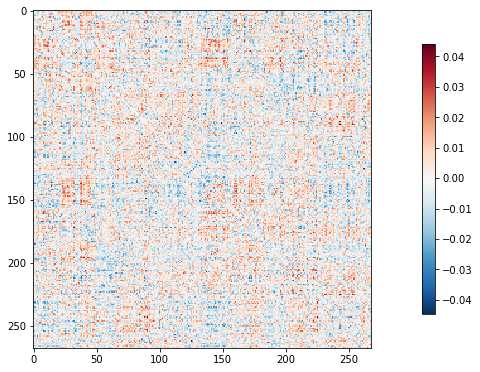

In [192]:
# view matrix, average of all subject, gain-loss
plotting.plot_matrix(np.mean(data_matrix, axis=0))

In [189]:
# view connectome, average of all subject, gain-loss
plotting.view_connectome(np.mean(data_matrix, axis=0),
                         edge_threshold=0.035,
                         node_coords=coords)

### Classify group

In [193]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

In [194]:
kinds = ['correlation', 'partial correlation', 'tangent']

# unique classes
_, classes = np.unique(group, return_inverse=True)


In [195]:
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:

cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)

pooled_subjects = np.asarray(pooled_subjects)